In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

In [2]:
path = "https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv"

In [3]:
df = pd.read_csv(path, parse_dates=['date'])

In [4]:
brazil = df.loc[(df.state == 'TOTAL')]

In [5]:
brazil_2020 = brazil.loc[
  (brazil['date'] >= "2020-02-25") & 
  (brazil['date'] <= "2020-12-31")
]

# Visualização

## Casos confirmados em 2020

In [6]:
px.line(brazil_2020, 'date', 'totalCases', title='Casos confirmados de COVID-19 no Brasil em 2020')

## Mortes em 2020

In [7]:
fig = go.Figure()
fig.add_trace(
  go.Scatter(x=brazil_2020.date, y=brazil_2020.deaths, name='Mortes',
             mode='lines+markers', line={'color': 'red'})
)
fig.update_layout(title='Mortes por COVID-19 no Brasil em 2020')
fig.show()

## Taxa de crescimento diária de casos confirmados em 2020

In [8]:
def daily_growth_rate(data, variable, initial_date=None):
  if initial_date == None:
    initial_date = data.date.loc[data[variable] > 0].min()
  else:
    initial_date = pd.to_datetime(initial_date)

  final_date = data.date.max()
  number_of_days = (final_date - initial_date).days
  rates = list(map(
    lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
    range(1, number_of_days+1)
  ))
  return np.array(rates) * 100

In [9]:
first_day = brazil_2020.date.loc[brazil_2020.totalCases > 0].min()

In [10]:
total_cases_rate = daily_growth_rate(brazil_2020, 'totalCases')

In [11]:
px.line(x=pd.date_range(first_day, brazil_2020.date.max())[1:], 
        y=total_cases_rate, title='Taxa de crescimento diária de casos confirmados de COVID-19 no Brasil em 2020')

# Predições

In [12]:
brazil_2020_total_cases = brazil_2020.totalCases
brazil_2020_total_cases.index = brazil_2020.date

In [13]:
brazil_2020_total_cases_decomposed = seasonal_decompose(brazil_2020_total_cases)

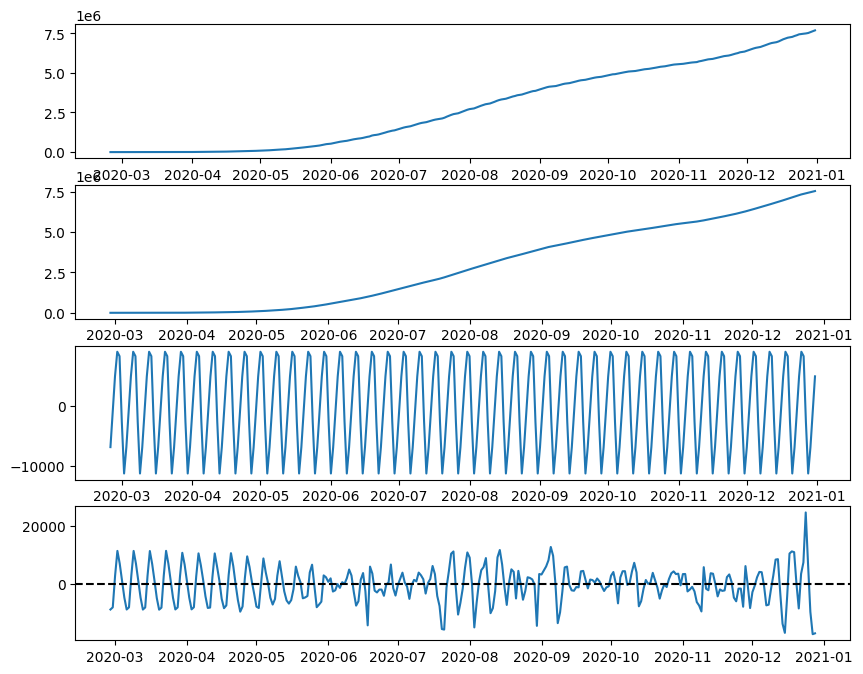

In [14]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

ax1.plot(brazil_2020_total_cases_decomposed.observed)
ax2.plot(brazil_2020_total_cases_decomposed.trend)
ax3.plot(brazil_2020_total_cases_decomposed.seasonal)
ax4.plot(brazil_2020_total_cases.index, brazil_2020_total_cases_decomposed.resid)
ax4.axhline(0, linestyle='dashed', color='black')

plt.show()

## ARIMA

In [15]:
model = auto_arima(brazil_2020_total_cases)

In [16]:
fig = go.Figure(go.Scatter(
  x=brazil_2020_total_cases.index, y=brazil_2020_total_cases, name='Observados'
))
fig.add_trace(go.Scatter(
  x=brazil_2020_total_cases.index, y=model.predict_in_sample(), name='Preditos'
))
fig.add_trace(go.Scatter(
  x=pd.date_range('2021-01-01', '2021-02-01'), y=model.predict(31), name='Forecast'
))
fig.update_layout(title='Previsão para casos confirmados de COVID-19 no Brasil em janeiro de 2021')

fig.show()

### ARIMA vs Real

In [17]:
brazil_2021 = brazil.loc[
  (brazil['date'] >= "2021-01-01") & 
  (brazil['date'] <= "2021-02-01")
]

In [18]:
brazil_2021_total_cases = brazil_2021.totalCases
brazil_2021_total_cases.index = brazil_2021.date

In [19]:
fig = go.Figure(go.Scatter(
  x=brazil_2021_total_cases.index, y=brazil_2021_total_cases, name='Real'
))
fig.add_trace(go.Scatter(
  x=pd.date_range('2021-01-01', '2021-02-01'), y=model.predict(32), name='ARIMA'
))
fig.update_layout(title='Previsão vs casos reais confirmados de COVID-19 no Brasil em janeiro de 2021')

fig.show()